In [1]:
from PIL import Image
import sys
import os
import urllib
import tensorflow as tf
import tensorflow.contrib.tensorrt as trt
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
from tf_trt_models.classification import download_classification_checkpoint, build_classification_graph

%matplotlib inline

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




In [2]:
MODEL = 'inception_v1'
CHECKPOINT_PATH = 'inception_v1.ckpt'
NUM_CLASSES = 1001
LABELS_PATH = './data/imagenet_labels_%d.txt' % NUM_CLASSES
IMAGE_PATH = './data/dog-yawning.jpg'

### Download the checkpoint and sample image

In [3]:
checkpoint_path = download_classification_checkpoint(MODEL, 'data')

### Build the frozen graph

In [4]:
frozen_graph, input_names, output_names = build_classification_graph(
    model=MODEL,
    checkpoint=checkpoint_path,
    num_classes=NUM_CLASSES
)





Instructions for updating:
Please use `layer.__call__` method instead.

INFO:tensorflow:Restoring parameters from data/inception_v1/inception_v1.ckpt
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 230 variables.
INFO:tensorflow:Converted 230 variables to const ops.


### Optimized the graph with TensorRT

In [5]:
trt_graph = trt.create_inference_graph(
    input_graph_def=frozen_graph,
    outputs=output_names,
    max_batch_size=1,
    max_workspace_size_bytes=1 << 25,
    precision_mode='FP16',
    minimum_segment_size=50
)

INFO:tensorflow:Linked TensorRT version: (7, 1, 0)
INFO:tensorflow:Loaded TensorRT version: (7, 1, 0)
INFO:tensorflow:Running against TensorRT version 7.1.0


### Create session and load graph

In [6]:
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True

tf_sess = tf.Session(config=tf_config)

tf.import_graph_def(trt_graph, name='')

tf_input = tf_sess.graph.get_tensor_by_name(input_names[0] + ':0')
tf_output = tf_sess.graph.get_tensor_by_name(output_names[0] + ':0')

### Download and preprocess image

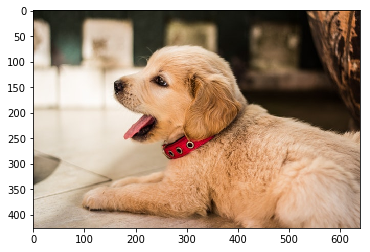

In [7]:
image = Image.open(IMAGE_PATH)

plt.imshow(image)

width = int(tf_input.shape.as_list()[1])
height = int(tf_input.shape.as_list()[2])

image = np.array(image.resize((width, height)))

### Execute model

In [8]:
output = tf_sess.run(tf_output, feed_dict={
    tf_input: image[None, ...]
})

scores = output[0]

### Get top 5 labels

In [9]:
with open(LABELS_PATH, 'r') as f:
    labels = f.readlines()

top5_idx = scores.argsort()[::-1][0:5]

for i in top5_idx:
    print('(%3f) %s' % (scores[i], labels[i]))

(0.357085) golden retriever

(0.043830) cocker spaniel, English cocker spaniel, cocker

(0.041014) toy poodle

(0.040536) miniature poodle

(0.014595) kuvasz



### Close session to release resources

In [10]:
tf_sess.close()